In [1]:
from reactionmodel.model import Species, Reaction, Model
import numpy as np
from numba import jit

X = Species('X')

@jit(nopython=True)
def k(t):
    return np.array([t/30])

r = Reaction([X], [], k=k)

m = Model([X], [r])

In [2]:
import hybrid.parse as parse

sf = parse.PreconfiguredSimulatorLoader.load_preconfigured('hr_original')
simulator = sf.make_simulator(
    m.get_k(jit=True),
    m.stoichiometry(),
    m.kinetic_order(),
)

In [3]:
x0 = 10000
t_span = (0.0, 5.0)
t = np.linspace(min(t_span), max(t_span), 51)
result = simulator.simulate(t_span, [x0], rng=np.random.default_rng(), t_eval=t)
result.status_counter

Counter({<HybridStepStatus.contrived_no_reaction: 4>: 48,
         <HybridStepStatus.t_end: 0>: 1})

[]

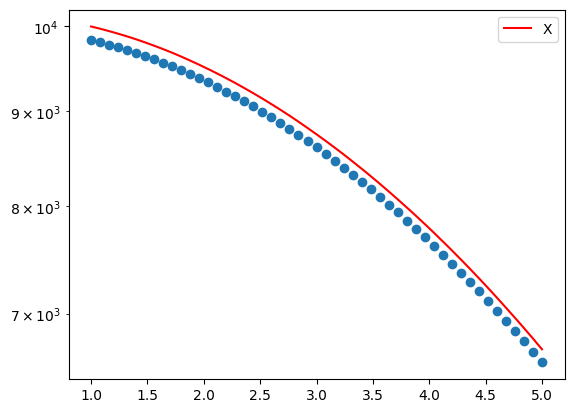

In [4]:
import matplotlib.pyplot as plt
ax = plt.subplot()

result.plot(m.legend(), ax=ax, c='r')
y = x0*np.exp(-1/60 * t**2)
ax.scatter(t, y)
ax.semilogy()

# Implicit tau leaping

In [5]:
from hybrid.tau import TauLeapSimulator

ts = TauLeapSimulator(
    m.get_k(jit=True),
    m.stoichiometry(),
    m.kinetic_order(),
    method='implicit',
    time_handling='inhomogeneous',
    epsilon=0.01
)

In [6]:
ts.time_handling

<TimeHandling.inhomogeneous: 'inhomogeneous'>

In [7]:
result = ts.simulate(t_span, [x0], rng=np.random.default_rng(), t_eval=t)
result.status_counter

0.15000000000000002 0.0050007307026252 0.030000000000000002
0.11625629117624271 0.00645126563859353 0.02348611942954398
0.09920230968745504 0.00756049929122068 0.02024536932397042
0.08905186832310431 0.008422070520532825 0.01836120996352666
0.08023272673664635 0.009349729258475261 0.01671515140346799
0.07455186616172102 0.01006053809971064 0.015695129718257057
0.06919939907405859 0.010838309358935377 0.01472327639873587
0.06504715130039344 0.011530107062853458 0.013988634688256655
0.06127637878767266 0.012243127933535491 0.013320951910363622
0.05817699951925616 0.01289279341951309 0.012786153740495859
0.05788753712085682 0.012957129781764738 0.012739334753709688
0.05759951790034702 0.013021800619953018 0.012685721374374412
0.05731293433910927 0.013086806542308363 0.012639306282745457
0.05702777898820651 0.013152148239428327 0.012586135287620063
0.05674404446523932 0.013217826469372357 0.012530428279836438
0.056461723451654615 0.01328384203718827 0.012484626523306714
0.05618080869059656

Counter({<TauStepStatus.stochastic: 4>: 900,
         <TauStepStatus.leap: 2>: 132,
         <TauStepStatus.rejected_for_gillespie: -2>: 9,
         <TauStepStatus.t_end: 0>: 1})

[]

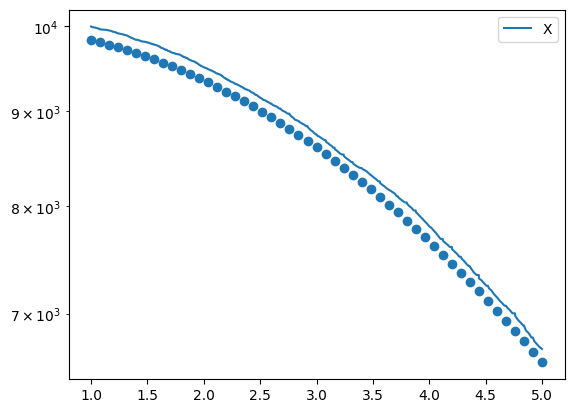

In [8]:
import matplotlib.pyplot as plt
ax = plt.subplot()

result.plot(m.legend(), ax=ax)
y = x0*np.exp(-1/60 * t**2)
ax.scatter(t, y)
ax.semilogy()